## Creates Fig. 4 comparing the observational to simulated data from Boseman et al. (2022)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [2]:
zthree = ["a=0.1588","a=0.1590","a=0.1593"]
zfour = ["a=0.1566","a=0.1570","a=0.1569"]
zfive = ["a=0.1540","a=0.1544","a=0.1539"]
zsix = ["a=0.1515","a=0.1518","a=0.1519"]
zseven = ["a=0.1499","a=0.1493","a=0.1500"]
zeight = ["a=0.1476","a=0.1477","a=0.1472"]
znine = ["a=0.1452","a=0.1453"]
zsix_zero =["a=0.1430","a=0.1429","a=0.1435"]
zsix_one = ["a=0.1400","a=0.1409","a=0.1401"]

In [50]:
"""""
load_and_process_files:
   - Loads data from CROC simulation.
   - Calculates optical depth data from flux.

split_data:
   - Splits the transformed data into training and testing sets.

redshift:
   - Splits the processed data into training and testing sets using split_data.
   - Returns the desired result based on redshift weighting to compare the observed and simulated data.
"""
def load_and_process_files(directory, res_files, valid_start_chars, target_files):
    all_data = []
    for subdir in os.listdir(directory):
        if subdir[0] in valid_start_chars:
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for file_name in target_files:
                    for res_file in res_files:
                        file_path = os.path.join(subdir_path, file_name, res_file)
                        if os.path.isfile(file_path):
                            df = pd.read_csv(file_path, delimiter=' ')
                            all_data.append(df)
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.rename(columns={'#': 'tau', '<tau>': 'length', 'length[km/s]': 'km_per_s'}, inplace=True)
    combined_df.drop(columns=['km_per_s', 'length'], inplace=True)
    all_tau_values = -np.log(combined_df.values.flatten())
    return all_tau_values

def split_data(all_tau_values, testsize):
    if testsize == 0:
        return all_tau_values, []
    elif testsize == 1:
        return [], all_tau_values
    else:
        train, test = train_test_split(all_tau_values, test_size=testsize, shuffle=True, random_state=100)
        return train, test

def redshift(directory, res_files, valid_start_chars, target_files, testsize, 
             target_files_two, testsize2, target_files_three, testsize3, 
             return_train1=False, return_train2=False, return_train3=True, num_samples=1000):
    
    all_tau_values = load_and_process_files(directory, res_files, valid_start_chars, target_files)
    all_tau_second = load_and_process_files(directory, res_files, valid_start_chars, target_files_two)
    all_tau_third = load_and_process_files(directory, res_files, valid_start_chars, target_files_three)
    
    train1, test1 = split_data(all_tau_values, testsize)
    train2, test2 = split_data(all_tau_second, testsize2)
    train3, test3 = split_data(all_tau_third, testsize3)
    
    result1 = train1 if return_train1 else test1
    result2 = train2 if return_train2 else test2
    result3 = train3 if return_train3 else test3
    
    return result1, result2, result3
direc = r'C:\Users\eawer\Downloads\C40-20240625T140952Z-001\C40'
ans = redshift(direc,["avgflux.x50.res"],['A','C','F'],zsix_one,.5,zsix_zero,1,znine,.5)

C:\Users\eawer\AppData\Local\Temp\ipykernel_4252\3914679931.py:16: RuntimeWarning: divide by zero encountered in log
  all_tau_values = -np.log(combined_df.values.flatten())


In [51]:
def cdf_redshift(los, combined_annotation, xy_position, num_samples=1000):
    """
    Plots the CDF vs. tau value for a specific redshift range of the observed CROC data.
    Parameters:
    los (int): the number of line of sight samples to take
    combined_annotation (string): a description of the redshift values being plotted, or any other information
    xy_position (tuple): the position of the annotation box on the graph
    num_samples (int): the number of random samples to take for computing percentiles
    
    Processes:
    - Creates quantiles of the simulated optical depth data.
    - Plots the CDF vs. tau plot.
    """
    one = np.linspace(0, 1, los)
    tau_samples = []
    tau1,tau2,tau3 = ans
    tau_combined = np.concatenate((tau1,tau2,tau3))
    q25_arr, q75_arr, q50_arr, q5_arr, q95_arr = [], [], [], [], []
    for _ in range(num_samples):
        sample = np.random.choice(tau_combined, los, replace=False)
        sample.sort()
        tau_samples.append(sample)

    for i in range(los):
        tau_1 = [sample[i] for sample in tau_samples]
        tau_1 = np.array(tau_1)
        q25 = np.quantile(tau_1, .25)
        q75 = np.quantile(tau_1, .75)
        q50 = np.quantile(tau_1, .5)
        q5 = np.quantile(tau_1, .05)
        q95 = np.quantile(tau_1, .95)
        q50_arr.append(q50)
        q25_arr.append(q25)
        q75_arr.append(q75)
        q5_arr.append(q5)
        q95_arr.append(q95)
    plt.plot(q50_arr, one, label='Median', color='black')
    #cdf_second(r'C:\Users\eawer\Downloads\C40-20240625T140952Z-001\C40',["avgflux.x50.res"],["a=0.1540","a=0.1544","a=0.1539"],['A','C','F'],10,'z=5.5',(3.5, .2))
    plt.fill_betweenx(one, q25_arr, q75_arr, color='gray', alpha=0.5, label='25% to 75%')
    plt.fill_betweenx(one, q5_arr, q95_arr, color='gray', alpha=0.2, label='5% to 95%')
    plt.xlabel(r'$\langle \tau_{\mathrm{GP}} \rangle_{50}$', fontsize=20)
    plt.ylabel(r'P(> $\langle \tau_{\mathrm{GP}} \rangle_{50}$)', fontsize=20)
    plt.xlim([0,5])
    bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
    plt.annotate(combined_annotation, xy=xy_position, bbox=bbox_props, ha='center', va='center')
    #plt.legend(loc='upper right')

In [53]:
def obs_twenty_two(file_path,err_file,redshift,combined_annotation,xy_pos,xlim):
    """
    Plots the CDF vs. tau values for observational data and associated error values to the simulated data.

    Parameters:
    file_path (str): Path to the input file containing observational data.
    err_file (str): Path to the separate file containing error values for the observational data.
    redshift (tuples): List of redshift ranges to process and plot.
    combined_annotation (str): Text description for plot.
    xy_pos (tuple): Coordinates for the annotation box on the graph.
    xlim (float): Upper limit for the x-axis of the plot.

    Process:
    - Loads and processes the observational data and corresponding error values.
    - For each redshift range, computes the CDF of mean flux values after converting them to tau values.
    - Creates two versions of the data:
      1. Original data with error values included.
      2. Modified data where the upper limits of flux are replaced with infinity.
    - Plots the CDF for both observational and simulated.
    """
    column_names = ['z_bin', 'usable_pixel_fraction', 'mean_z_at_usable', 
                'mean_flux', '+1_sigma_err', '-1_sigma_err', 'z_qso']
    df = pd.read_csv(file_path,header=None,delim_whitespace=True,names=column_names)
    err = pd.read_csv(err_file,header=None,delim_whitespace=True,names=column_names)
    df= df.dropna()
    err = err.dropna()
    err1 = err.copy()
    err['mean_flux'] = err['+1_sigma_err']
    err1['mean_flux'] = np.exp(-101)
    
    df=df.sort_values(by='mean_z_at_usable') #sorting values of redshift numerically
    obs_list = []
    for z_min, z_max in redshift: #for lower bound, 0
        obs_df = df[(df['mean_z_at_usable'] >= z_min) & (df['mean_z_at_usable'] <= z_max)]
        obs_df['mean_flux'] = -np.log(obs_df['mean_flux'])
        err = err[(err['mean_z_at_usable'] >= z_min) & (err['mean_z_at_usable'] <= z_max)]
        err['mean_flux'] = -np.log(err['mean_flux'])
        print(f"Number of values in 'err' for z range ({z_min}, {z_max}): {len(err['mean_flux'])}")
        result = pd.concat([obs_df,err],ignore_index=True)
        result = result.sort_values(by='mean_flux')
        print(len(result))
        obs_list.append(result)
    obs_list_new = []
    for z_min, z_max in redshift:
        obs_df_new = df[(df['mean_z_at_usable'] >= z_min) & (df['mean_z_at_usable'] <= z_max)]
        obs_df_new['mean_flux'] = -np.log(obs_df_new['mean_flux'])
        obs_df_new = obs_df_new.sort_values(by='mean_flux')
        err1 = err1[(err1['mean_z_at_usable'] >= z_min) & (err1['mean_z_at_usable'] <= z_max)]
        err1['mean_flux'] = -np.log(err1['mean_flux'])
        result1 = pd.concat([obs_df_new,err1],ignore_index=True)
        result1 = result1.sort_values(by='mean_flux')
        obs_list_new.append(result1)
    prob_list = []
    for result in obs_list: #remove iteration
        result['mean_flux'] = pd.to_numeric(result['mean_flux'], errors='coerce')
        if len(err.index) > 0:
            end_row = pd.DataFrame({'mean_flux':[100]})
            bins_arr = pd.concat([result,end_row],ignore_index=True)
        else:
            bins_arr = result
        hist, bins = np.histogram(result['mean_flux'], bins=bins_arr['mean_flux'])
        cumulative_counts = np.cumsum(hist)
        prob = cumulative_counts / len(result['mean_flux'])
        prob_df = pd.DataFrame({
            'tau':(bins[1:]+bins[:-1])/2,
            'probability': prob
        })
        prob_list.append(prob_df)
    prob_list_new = []
    for result1 in obs_list_new:
        result1['mean_flux'] = pd.to_numeric(result1['mean_flux'], errors='coerce')
        hist, bins_new = np.histogram(result1['mean_flux'], bins=bins)
        cumulative_counts = np.cumsum(hist)
        prob_new = cumulative_counts / len(result1['mean_flux'])
        prob_df_new = pd.DataFrame({
            'tau': (bins_new[1:]+bins_new[:-1])/2,
            'probability': prob_new
        })
        prob_list_new.append(prob_df_new)
    plt.figure(figsize=(10, 5))
    for j, prob_df_new in enumerate(prob_list_new):
        z_min,z_max = redshift[j]
        plt.plot(prob_df_new['tau'],prob_df_new['probability'],color = 'blue',linestyle = 'dotted')
    for i, prob_df in enumerate(prob_list):
        z_min, z_max = redshift[i]
        plt.plot(prob_df['tau'], prob_df['probability'], label='Bosman et al. 2022',color = 'blue',linestyle = 'dotted')
        plt.fill_between(prob_df['tau'], prob_df['probability'], prob_df_new['probability'], color='blue', hatch='///', alpha=0.3)
    bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
    plt.annotate(combined_annotation, xy=xy_pos, 
            bbox=bbox_props, ha='center', va='center',fontsize=25)
    cdf_redshift(17,'z=5.3 & z=5.4',(3.5, 10))
    plt.xlim([3, xlim])
    plt.xlabel(r'$\langle \tau_{\mathrm{GP}} \rangle_{50}$', fontsize=23)
    plt.ylabel(r'P(< $\langle \tau_{\mathrm{GP}} \rangle_{50}$)', fontsize=23)
    plt.tick_params(axis='both', which='major', labelsize=15) 
    #plt.legend(loc='upper left',fontsize=14)
    plt.show()

C:\Users\eawer\AppData\Local\Temp\ipykernel_4252\1976272100.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df['mean_flux'] = -np.log(obs_df['mean_flux'])
C:\Users\eawer\AppData\Local\Temp\ipykernel_4252\1976272100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_new['mean_flux'] = -np.log(obs_df_new['mean_flux'])


Number of values in 'err' for z range (5.9, 6.1): 5
17


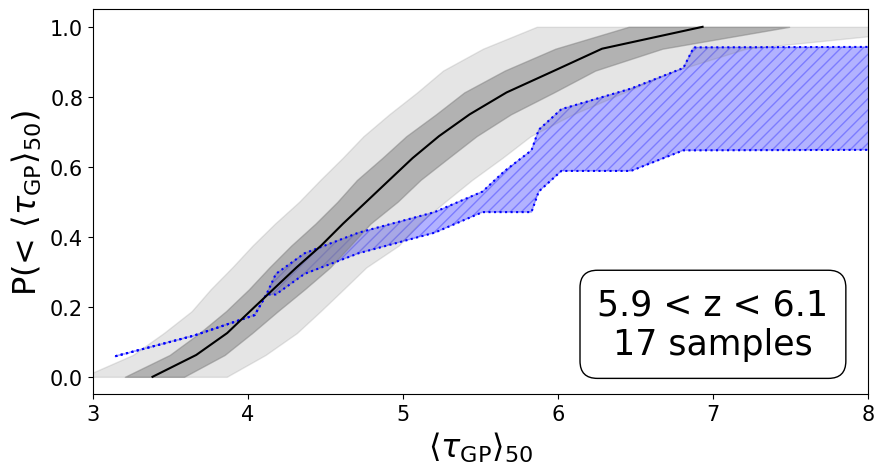

In [57]:
obs_twenty_two(r'C:\Users\eawer\Downloads\REU\stac1046_supplemental_file\all-lya-dz02.dat',r'C:\Users\eawer\Downloads\REU\stac1046_supplemental_file\all-lya-limits-dz02.dat',[(5.9,6.1)],'5.9 < z < 6.1\n17 samples',(7,.15),8)